# Интерактивная карта фрактального множества
# Группа БПМ213 Кацуба Кирилл 
# 11 вариант
## Бассейны Ньютона 
# $p(z) = z^3 - 2z + 2$

### Условие задачи

**Дано:**

Варианты фрактальных множеств:

- [фрактал Ляпунова](https://ru.wikipedia.org/wiki/Фрактал_Ляпунова)
  1. AB
  2. BBBBBBAAAAAA
  3. AABAB
  4. ABBBCA

- [множество Жюлиа](https://ru.wikipedia.org/wiki/Множество_Жюлиа)
  5. $z_{n+1} = z^3_n + c$
  6. $z_{n+1} = z^4_n + c$
  7. $z_{n+1} = z^3_n + z^2_n + c$
  8. $z_{n+1} = z^4_n + z^3_n + c$

- [бассейны Ньютона](https://ru.wikipedia.org/wiki/Бассейны_Ньютона)
  9. $p(z) = z^3 - 1$
  10. $p(z) = z^8 + 15z^4 - 16$
  11. $p(z) = z^3 - 2z + 2$
  12. $p(z) = sin(z)$


Обозначим за $\lambda$:
 - количество итераций (множество Жюлиа),
 - количество итераций для достижения заданной погрешности достижения корня (бассейны Ньютона)
 - экспонента Ляпунова (фрактал Ляпунова)

**Требуется**

 - реализовать функции и откомпилировать их при помощи модуля `Numba`:
     - расчет $\lambda$ для точки на комплексной плоскости
     - расчет $\lambda$ на регулярной решетке на комплексной плоскости (эта функция должна быть распараллелена при помощи `prange`)

 - создать интерактивную карту при помощи класса `DynamicMap` модуля `holoviews`:
     - цветом отобразить значение $\lambda$
     - выбрать цветовую карту [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
     - размеры карты - не менее 600 х 600 точек
     - отрегулировать количество итераций так, чтобы время вычисления одного обновления карты было менее 1 секунды

 - сохранить 5 различных изображений:
     - найти красивые места на карте, применив переносы и масштабирования
     - воспользоваться кнопкой сохранения на интерактивной карте

 - добавить описание:
     - к каждой константе (комментарий)
     - к каждой функции (`docstring`)

**Правила оценивания:**

- оценка за корректно реализованные функции и созданную интерактивную карту `100` баллов

- штрафы $p(i)$, баллов:
    - не работает интерактивная карта - 50
    - ошибки в реализации функций - 20
    - не выполнена компиляция и распараллеливание - 20
    - отсутствует 5 изображений - 20
    - отсутствует `docstring` - 20
    - менее значимые недоработки - 10
    - другие ошибки штрафуются индивидуально в зависимости от их тяжести

- итоговая оценка за задание = $100 - \sum_{i}{p(i)}$

## Выполнение задания

Исходя из данной в 11 варианте функции $p(z) = z^3 - 2z + 2$, найдем производную и построим рекурентные соотношения для $z_n$

### $p^{\prime}(z) = 3z^2 - 2$

Получим формулу для нахождения корня: 
### $z_{n+1} = z_n - \frac{p(z_n)}{p^{\prime}(z_n)}$   (1)

По условию в качетве количества итераций для достижения необходимой погрешности обозначили за $\lambda$ (в коде будем писать lmd), а погрешность $\epsilon$ = 0.001 (в коде будем писать eps).

Максимальное цисло иттераций обозначим maxit.

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange
import holoviews as hv
# from holoviews import opts
# from holoviews.streams import RangeXY

Далее обозначим:
1. z0 - начальное значени для итеративного процесса
2. eps - погрешность, до которой итеративно будут искаться корни

Для повышения скорости выполнения функции бкдем пользоваться декоратором @njit из open source Numba, а также воспользуемся распараллеливанием задач.

In [2]:
@njit(fastmath = True)
def newton_fractal_point(z0: complex, eps: float = 0.001, maxit:int = 1000) -> int:
    '''
    Данная функция будет искать приближение к корням функции p(z), 
    с заданной начальной позицией z0 и точностью eps (метод Ньютона)
    Возвращает номер итерации (lmd), на которой из начального z0 получится корень, с приближенной точностью
    '''
    z = z0
    for lmd in range(maxit):
        z1 = z #фиксируем z_{n-1}
        z = z - (z**8 + 15*(z**4) - 16)/(8*(z**7) + 60*(z**3)) #считаем z_{n}
        if abs(z - z1) < eps: #удовлетворяет ли корень погрешности eps
            return lmd
    return maxit
print(newton_fractal_point(z0=7))

15


Далее обозначим:
1. nx, ny - размеры решетки по дейстивельной оси и мнимой оси
2. xmin, xmax, ymin, ymax - граничные точки(минимум и максимум) по действительной оси и мнимой оси
3. dx, dy - разбиение отрезка по каждой из осей на множестов точек
4. arr - массив, в который записывается количество итераций, которое понадобится чтобы приблизиться к корню, с заданной погрешностью и начальной точкой

Для повышения скорости выполнения функции будем пользоваться декоратором @njit из open source Numba, а также воспользуемся распараллеливанием задач.

In [3]:
@njit(parallel = True, fastmath = True)
def newton_fractal(xmax: float, xmin: float, ymax: float, ymin: float, 
                   nx: int, ny: int, maxit:int = 1000) -> np.array([[np.uint16]]):
    '''
    Данная функция в каждой точке сетки, с заданным разбиением,
    использует функцию для использования метода Ньютона newton_fractal_point.
    Возвращаемым значением будет матрица размерами (ny + 1,nx + 1),
    которая будет основой для посторения бассйена Ньютона
    '''
    dx = (xmax - xmin)/nx #разбитие действительной оси на малеьнкие промежутки длины dx
    dy = (ymax - ymin)/ny #разбитие мнимой оси на малеьнкие промежутки длины dy
    arr = np.empty((ny + 1, nx + 1), dtype=np.uint16)
    for iy in prange(ny + 1):
        for ix in range(nx + 1):
            x = xmin + dx * ix #выбор точки на действительной оси 
            y = ymin + dy * iy #выбор точки на мнимой оси
            lambda_ = newton_fractal_point(z0=x+1j*y, maxit=maxit) #нахождение лямбды для начальной точки z0 = complex(x, y)
            arr[iy, ix] = lambda_ #записываем полученную лямбда в матриццу arr
    return arr
print(newton_fractal(1,-1,1,-1,1,1))

[[6 6]
 [6 6]]


In [4]:
def fractal(x_range:float, y_range:float):
    """
    функция для построения фрактала, вызывает в своем теле функцию newton_fractal
    для расчета lambda на рештке
    Возвращает изображение holoviews
    """
    x0, x1 = x_range #размер решетки по действительной оси
    y0, y1 = y_range #размер решетки по мнимой оси
    arr = newton_fractal(x1, x0, -y0, -y1, image_width, image_height,maxit)
    
    return hv.Image(arr, bounds=(x0, y0, x1, y1))

Далее используя все выше описанные функции посторим динамическую карту с заданными размерами изображения и количесивом итераций для подсчтета lambda.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
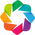

:DynamicMap   []
   :Image   [x,y]   (z)

In [7]:
hv.extension('bokeh')
image_width, image_height = 800, 800 # размеры построенной карты
maxit = 1000 # максимальное количество итераций для нахождения приближенного с точностью eps корня
# максимальное и минимальное значение по мнимой и вещественной оси,
# диапазон решетки
xmin, xmax = -1.5, 0.5
ymin, ymax = 0.0, 2.0

# определение потока RangeXY для изображения
range_xy = hv.streams.RangeXY(x_range=(xmin, xmax),
                              y_range=(ymin, ymax))

#построение динамической карты фрактала
dmap = hv.DynamicMap(fractal, streams=[range_xy])
dmap.opts(hv.opts.Image(height=image_height, width=image_width, 
                        cmap='Reds', logz=True))

Далее засечем время выполнения функции fractal, которая строит изображение фрактала 

In [19]:
print(timeit.timeit('fractal(x_range=(xmin, xmax),y_range=(ymin, ymax))', globals=globals(), number=100)/100)

0.24444544707999738


Как видим, время одного обновления карты составляет минее 0.5 секунд